# Chapter 4 - Estimating Proportions

In the previous chapter we solved the 101 Bowls Problem, and I admitted that it is not really about guessing which bowl the cookies came from; it is about estimating proportions.

In this chapter, we take another step toward Bayesian statistics by solving the Euro problem.
We'll start with the same prior distribution, and we'll see that the update is the same, mathematically.
But I will argue that it is a different problem, philosophically, and use it to introduce two defining elements of Bayesian statistics: choosing prior distributions, and using probability to represent the unknown.

## The Euro Problem

In *Information Theory, Inference, and Learning Algorithms*, David MacKay poses this problem:

"A statistical statement appeared in *The Guardian* on Friday January 4, 2002:

> When spun on edge 250 times, a Belgian one-euro coin came up heads 140 times and tails 110.  \`It looks very suspicious to me,' said Barry Blight, a statistics lecturer at the London School of Economics.  \`If the coin were unbiased, the chance of getting a result as extreme as that would be less than 7%.'

"But [MacKay asks] do these data give evidence that the coin is biased rather than fair?"

To answer that question, we'll proceed in two steps.
First we'll use the binomial distribution to see where that 7% came from; then we'll use Bayes's Theorem to estimate the probability that this coin comes up heads.


## The Binomial Distribution

Suppose I tell you that a coin is "fair", that is, the probability of heads is 50%.  If you spin it twice, there are four outcomes: `HH`, `HT`, `TH`, and `TT`.  All four outcomes have the same probability, 25%.

If we add up the total number of heads, there are three possible results: 0, 1, or 2.  The probabilities of 0 and 2 are 25%, and the probability of 1 is 50%.

More generally, suppose the probability of heads is $p$ and we spin the coin $n$ times.  The probability that we get a total of $k$ heads is given by the [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution):

$$\binom{n}{k} p^k (1-p)^{n-k}$$

for any value of $k$ from 0 to $n$, including both.
The term $\binom{n}{k}$ is the [binomial coefficient](https://en.wikipedia.org/wiki/Binomial_coefficient), usually pronounced "n choose k".

We could evaluate this expression ourselves, but we can also use the SciPy function `binom.pmf`.
For example, if we flip a coin `n=2` times and the probability of heads is `p=0.5`, here's the probability of getting `k=1` heads:

In [1]:
from scipy.stats import binom

n = 2
p = 0.5
k = 1

binom.pmf(k, n, p)

0.5000000000000002

Instead of providing a single value for `k`, we can also call `binom.pmf` with an array of values.

In [2]:
import numpy as np
ks = np.arange(n+1)

ps = binom.pmf(ks, n, p)
ps

array([0.25, 0.5 , 0.25])

The result is a NumPy array with the probability of 0, 1, or 2 heads.
If we put these probabilities in a `Pmf`, the result is the distribution of `k` for the given values of `n` and `p`.

Here's what it looks like:

In [3]:
from empiricaldist import Pmf

pmf_k = Pmf(ps, ks)
pmf_k

,probs
0,0.25
1,0.50
2,0.25


The following function computes the binomial distribution for given values of `n` and `p` and returns a `Pmf` that represents the result.

In [4]:
def make_binomial(n, p):
    
    """Make a binomial Pmf."""
    
    ks = np.arange(n+1)
    ps = binom.pmf(ks, n, p)
    return Pmf(ps, ks)

#make_binomial(n,p) = np.array([np.math.comb(n, k) * (p ** k) * ((1 - p) ** (n - k)) for k in x])

Here's what it looks like with `n=250` and `p=0.5`:

In [5]:
pmf_k = make_binomial(n=250, p=0.5)
pmf_k

,probs
0,5.527148e-76
1,1.381787e-73
2,1.720325e-71
3,1.422135e-69
4,8.781685e-68
...,...
246,8.781685e-68
247,1.422135e-69
248,1.720325e-71
249,1.381787e-73


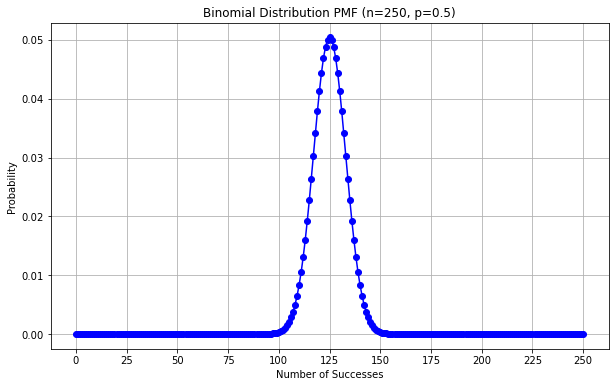

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the binomial distribution
n = 250  # Number of trials
p = 0.5  # Probability of success

# Generate the x values (number of successes)
x = np.arange(0, n+1)

# Calculate the probability mass function (PMF) for each x value
pmf = make_binomial(n=250, p=0.5)

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the probability mass function
plt.plot(x, pmf, color='blue', marker='o', linestyle='-')

# Set x-axis ticks to be in intervals of 25
plt.xticks(np.arange(0, n+1, 25))

# Add labels and title
plt.title('Binomial Distribution PMF (n=250, p=0.5)')
plt.xlabel('Number of Successes')
plt.ylabel('Probability')

# Show plot
plt.grid(True)
plt.show()

The most likely quantity in this distribution is 125:

In [7]:
pmf_k.max_prob()

125

But even though it is the most likely quantity, the probability that we get exactly 125 heads is only about 5%.

In [8]:
pmf_k[125]

0.050412213147309655

In MacKay's example, we got 140 heads, which is even less likely than 125:

In [9]:
pmf_k[140]

0.008357181724918204

In the article MacKay quotes, the statistician says, "If the coin were unbiased the chance of getting a result as extreme as that would be less than 7%."

We can use the binomial distribution to check his math.  The following function takes a PMF and computes the total probability of quantities greater than or equal to `threshold`. 

In [10]:
def prob_ge(pmf, threshold):
    
    """Probability of quantities greater than threshold."""
    
    ge = (pmf.qs >= threshold)
    total = pmf[ge].sum()
    return total

Here's the probability of getting 140 heads or more:

In [11]:
prob_ge(pmf_k, 140)

0.03321057562002164

`Pmf` provides a method that does the same computation.

In [12]:
pmf_k.prob_ge(140)

0.03321057562002164

The result is about 3.3%, which is less than the quoted 7%.  The reason for the difference is that the statistician includes all outcomes "as extreme as" 140, which includes outcomes less than or equal to 110.

To see where that comes from, recall that the expected number of heads is 125.  If we get 140, we've exceeded that expectation by 15.
And if we get 110, we have come up short by 15.

7% is the sum of both of these "tails", as shown in the following figure.

Here's how we compute the total probability of the left tail.

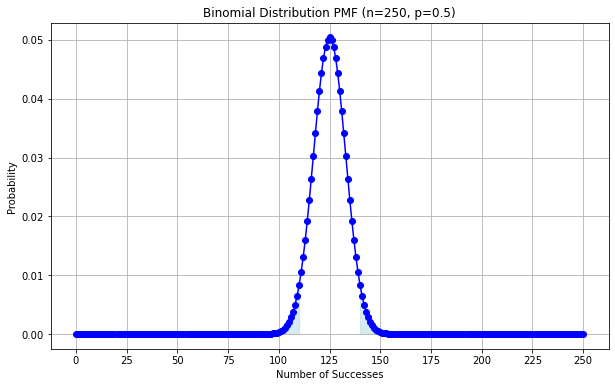

In [13]:
# Parameters for the binomial distribution
n = 250  # Number of trials
p = 0.5  # Probability of success

# Generate the x values (number of successes)
x = np.arange(0, n+1)

# Calculate the probability mass function (PMF) for each x value
pmf = np.array([np.math.comb(n, k) * (p ** k) * ((1 - p) ** (n - k)) for k in x])

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the probability mass function
plt.plot(x, pmf, color='blue', marker='o', linestyle='-')

# Fill the area below the PMF between x-values where x is greater than or equal to 140
plt.fill_between(x[x>=140], pmf[x>=140], color='lightblue', alpha=0.5)

# Fill the area below the PMF between x-values where x is less than or equal to 110
plt.fill_between(x[x<=110], pmf[x<=110], color='lightblue', alpha=0.5)

# Set x-axis ticks to be in intervals of 25
plt.xticks(np.arange(0, n+1, 25))

# Add labels and title
plt.title('Binomial Distribution PMF (n=250, p=0.5)')
plt.xlabel('Number of Successes')
plt.ylabel('Probability')

# Show plot
plt.grid(True)
plt.show()

The probability of outcomes less than or equal to 110 is also 3.3%,
so the total probability of outcomes "as extreme" as 140 is 6.6%.

The point of this calculation is that these extreme outcomes are unlikely if the coin is fair.

That's interesting, but it doesn't answer MacKay's question.  Let's see if we can.

In [14]:
pmf_k.prob_le(110)

0.03321057562002164

## Bayesian Estimation

Any given coin has some probability of landing heads up when spun
on edge; I'll call this probability `x`.
It seems reasonable to believe that `x` depends
on physical characteristics of the coin, like the distribution
of weight.
If a coin is perfectly balanced, we expect `x` to be close to 50%, but
for a lopsided coin, `x` might be substantially different.
We can use Bayes's theorem and the observed data to estimate `x`.

For simplicity, I'll start with a uniform prior, which assumes that all values of `x` are equally likely.
That might not be a reasonable assumption, so we'll come back and consider other priors later.

We can make a uniform prior like this:

In [15]:
# Define hypotheses
hypos = np.linspace(0, 1, 101)

# Construct a uniform prior
prior = np.full_like(hypos, 1/len(hypos))

# Define likelihoods
likelihood_heads = hypos
likelihood_tails = 1 - hypos

# Construct likelihood dictionary
likelihood = {'H': likelihood_heads, 'T': likelihood_tails}

# Define the dataset
dataset = 'H' * 140 + 'T' * 110

In [16]:
def update_euro(pmf, dataset):
    """Update pmf with a given sequence of H and T."""
    for data in dataset:
        pmf *= likelihood[data]

    pmf /= pmf.sum()  # Normalize

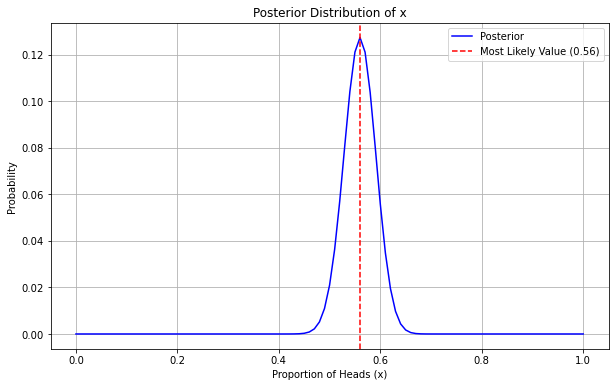

In [17]:
# Initialize posterior as a copy of prior
posterior = prior.copy()

# Update the posterior
update_euro(posterior, dataset)

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the posterior distribution
plt.plot(hypos, posterior, label='Posterior', color='blue')
plt.axvline(x=0.56, color='red', linestyle='--', label='Most Likely Value (0.56)')
plt.xlabel('Proportion of Heads (x)')
plt.ylabel('Probability')
plt.title('Posterior Distribution of x')
plt.legend()
plt.grid(True)
plt.show()

This figure shows the posterior distribution of x, which is the proportion of heads for the coin we observed.

The posterior distribution represents our beliefs about x after seeing the data. It indicates that values less than 0.4 and greater than 0.7 are unlikely; values between 0.5 and 0.6 are the most likely.

In fact, the most likely value for x is 0.56 which is the proportion of heads in the dataset, 140/250.

In [18]:
most_likely_value = hypos[np.argmax(posterior)]
most_likely_value

0.56

## Triangle Prior

But that might not be a reasonable choice based on what we know about coins. I can believe that if a coin is lopsided, x might deviate substantially from 0.5, but it seems unlikely that the Belgian Euro coin is so imbalanced that x is 0.1 or 0.9.

It might be more reasonable to choose a prior that gives higher probability to values of x near 0.5 and lower probability to extreme values.

As an example, let’s try a triangle-shaped prior. Here’s the code that constructs it:

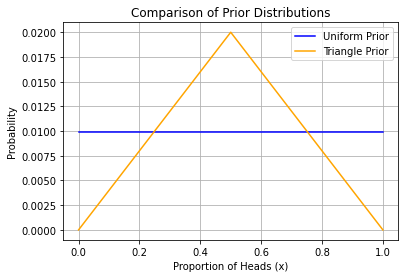

In [19]:
# Define hypotheses
hypos = np.linspace(0, 1, 101)

# Create a uniform prior
uniform_prior = np.full_like(hypos, 1/len(hypos))

# Construct a triangle-shaped prior
ramp_up = np.arange(50)
ramp_down = np.arange(50, -1, -1)
triangle_prior = np.append(ramp_up, ramp_down)

# Normalize priors
uniform_prior = uniform_prior.astype(float) / uniform_prior.sum()
triangle_prior = triangle_prior.astype(float) / triangle_prior.sum()

# Plot the priors
plt.plot(hypos, uniform_prior, label='Uniform Prior', color='blue')
plt.plot(hypos, triangle_prior, label='Triangle Prior', color='orange')
plt.xlabel('Proportion of Heads (x)')
plt.ylabel('Probability')
plt.title('Comparison of Prior Distributions')
plt.legend()
plt.grid(True)
plt.show()

Now we can update both priors with the same data:

In [20]:
# Define hypotheses
hypos = np.linspace(0, 1, 101)

# Define the dataset
dataset = 'H' * 700 + 'T' * 300  # 700 heads and 300 tails

# Define different priors: uniform and triangular
uniform_prior = np.full_like(hypos, 1/len(hypos))
triangular_prior = np.where(hypos <= 0.5, 2 * hypos, 2 * (1 - hypos))

# Define likelihoods
likelihood_heads = hypos
likelihood_tails = 1 - hypos
likelihood = {'H': likelihood_heads, 'T': likelihood_tails}

In [21]:
def update_euro(prior, dataset):
    """Update prior with a given sequence of H and T."""
    posterior = prior.copy()
    for data in dataset:
        posterior *= likelihood[data]
    posterior /= posterior.sum()  # Normalize
    return posterior

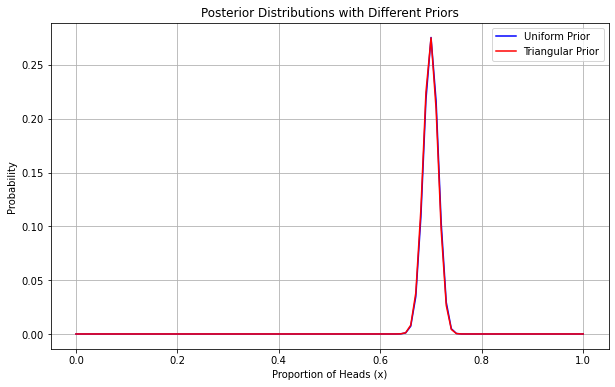

In [22]:
# Update priors with the dataset
posterior_uniform = update_euro(uniform_prior, dataset)
posterior_triangular = update_euro(triangular_prior, dataset)

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the posterior distributions
plt.plot(hypos, posterior_uniform, label='Uniform Prior', color='blue')
plt.plot(hypos, posterior_triangular, label='Triangular Prior', color='red')
plt.xlabel('Proportion of Heads (x)')
plt.ylabel('Probability')
plt.title('Posterior Distributions with Different Priors')
plt.legend()
plt.grid(True)
plt.show()

The differences between the posterior distributions are barely visible, and so small they would hardly matter in practice.

And that’s good news. To see why, imagine two people who disagree angrily about which prior is better, uniform or triangle. Each of them has reasons for their preference, but neither of them can persuade the other to change their mind.

But suppose they agree to use the data to update their beliefs. When they compare their posterior distributions, they find that there is almost nothing left to argue about.

This is an example of swamping the priors: with enough data, people who start with different priors will tend to converge on the same posterior distribution.

## The Binomial Likelihood Function

So far we've been computing the updates one spin at a time, so for the Euro problem we have to do 250 updates.

A more efficient alternative is to compute the likelihood of the entire dataset at once.
For each hypothetical value of `x`, we have to compute the probability of getting 140 heads out of 250 spins.

Well, we know how to do that; this is the question the binomial distribution answers.
If the probability of heads is $p$, the probability of $k$ heads in $n$ spins is:

$$\binom{n}{k} p^k (1-p)^{n-k}$$

And we can use SciPy to compute it.
The following function takes a `Pmf` that represents a prior distribution and a tuple of integers that represent the data:

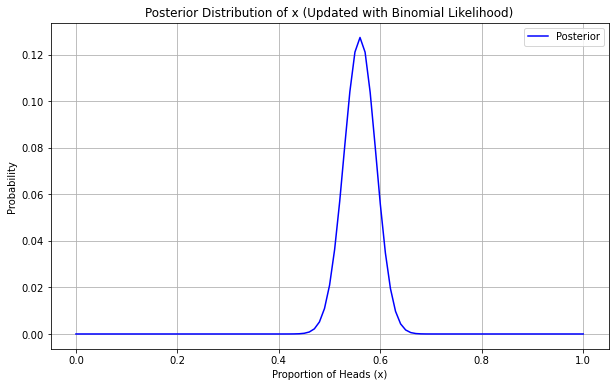

In [23]:
# Define hypotheses
hypos = np.linspace(0, 1, 101)

# Define a function to update the prior using the binomial likelihood
def update_binomial(pmf, data):
    """Update pmf using the binomial distribution."""
    k, n = data
    xs = np.linspace(0, 1, len(pmf))  # Generate values between 0 and 1
    likelihood = binom.pmf(k, n, xs)
    pmf *= likelihood
    pmf /= pmf.sum()  # Normalize

# Create a uniform prior
uniform_prior = np.full_like(hypos, 1/len(hypos))

# Define the data
data = 140, 250  # Number of heads and number of spins

# Update the prior using the binomial likelihood
update_binomial(uniform_prior, data)

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the posterior distribution
plt.plot(hypos, uniform_prior, label='Posterior', color='blue')
plt.xlabel('Proportion of Heads (x)')
plt.ylabel('Probability')
plt.title('Posterior Distribution of x (Updated with Binomial Likelihood)')
plt.legend()
plt.grid(True)
plt.show()

## Bayesian Statistics

You might have noticed similarities between the Euro problem and the 101 Bowls Problem in <<_101Bowls>>.
The prior distributions are the same, the likelihoods are the same, and with the same data the results would be the same.
But there are two differences.

The first is the choice of the prior.
With 101 bowls, the uniform prior is implied by the statement of the problem, which says that we choose one of the bowls at random with equal probability.

In the Euro problem, the choice of the prior is subjective; that is, reasonable people could disagree, maybe because they have different information about coins or because they interpret the same information differently.

Because the priors are subjective, the posteriors are subjective, too.
And some people find that problematic.

The other difference is the nature of what we are estimating.
In the 101 Bowls problem, we choose the bowl randomly, so it is uncontroversial to compute the probability of choosing each bowl.
In the Euro problem, the proportion of heads is a physical property of a given coin.
Under some interpretations of probability, that's a problem because physical properties are not considered random.

As an example, consider the age of the universe.
Currently, our best estimate is 13.80 billion years, but it might be off by 0.02 billion years in either direction (see [here](https://en.wikipedia.org/wiki/Age_of_the_universe)).

Now suppose we would like to know the probability that the age of the universe is actually greater than 13.81 billion years.
Under some interpretations of probability, we would not be able to answer that question.
We would be required to say something like, "The age of the universe is not a random quantity, so it has no probability of exceeding a particular value."

Under the Bayesian interpretation of probability, it is meaningful and useful to treat physical quantities as if they were random and compute probabilities about them.

In the Euro problem, the prior distribution represents what we believe about coins in general and the posterior distribution represents what we believe about a particular coin after seeing the data.
So we can use the posterior distribution to compute probabilities about the coin and its proportion of heads.

The subjectivity of the prior and the interpretation of the posterior are key differences between using Bayes's Theorem and doing Bayesian statistics.

Bayes's Theorem is a mathematical law of probability; no reasonable person objects to it.
But Bayesian statistics is surprisingly controversial.
Historically, many people have been bothered by its subjectivity and its use of probability for things that are not random.

If you are interested in this history, I recommend Sharon Bertsch McGrayne's book, *[The Theory That Would Not Die](https://yalebooks.yale.edu/book/9780300188226/theory-would-not-die)*.

## Exercises

**Exercise:** In Major League Baseball, most players have a batting average between .200 and .330, which means that their probability of getting a hit is between 0.2 and 0.33.

Suppose a player appearing in their first game gets 3 hits out of 3 attempts.  What is the posterior distribution for their probability of getting a hit?

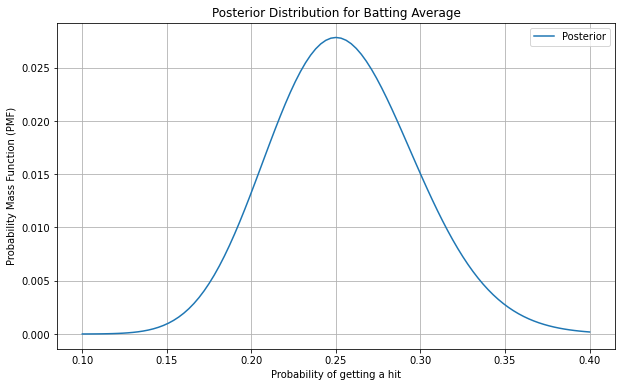

In [24]:
# Define hypotheses
hypos = np.linspace(0.1, 0.4, 101)

# Create a uniform prior
prior = np.full_like(hypos, 1/len(hypos))

# Define likelihoods
likelihood = {'Y': hypos, 'N': 1 - hypos}

# Define the dataset
dataset = 'Y' * 25 + 'N' * 75

# Update the prior with the dataset
for data in dataset:
    prior *= likelihood[data]

# Normalize the prior
prior /= prior.sum()

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the prior distribution
plt.plot(hypos, prior, label='Posterior')
plt.xlabel('Probability of getting a hit')
plt.ylabel('Probability Mass Function (PMF)')
plt.title('Posterior Distribution for Batting Average')
plt.legend()
plt.grid(True)
plt.show()

This distribution indicates that most players have a batting average near 250, with only a few players below 175 or above 350. I’m not sure how accurately this prior reflects the distribution of batting averages in Major League Baseball, but it is good enough for this exercise.

Now update this distribution with the data and plot the posterior. What is the most likely quantity in the posterior distribution?

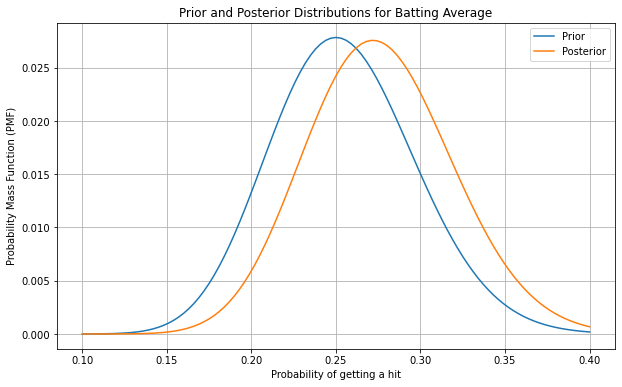

Most likely quantity in the prior distribution: 0.25
Most likely quantity in the posterior distribution: 0.271


In [25]:
from empiricaldist import Pmf

# Define hypotheses
hypos = np.linspace(0.1, 0.4, 101)

# Create a uniform prior
prior = Pmf(1, hypos)

# Define likelihoods
likelihood = {'Y': hypos, 'N': 1 - hypos}

# Define the dataset
dataset = 'Y' * 25 + 'N' * 75

# Update the prior with the dataset
for data in dataset:
    prior *= likelihood[data]

# Normalize the prior
prior.normalize()

# Copy the prior to posterior
posterior = prior.copy()

# Update the posterior with the dataset
for data in 'YYY':
    posterior *= likelihood[data]

# Normalize the posterior
posterior.normalize()

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the prior and posterior distributions
prior.plot(label='Prior')
posterior.plot(label='Posterior')
plt.xlabel('Probability of getting a hit')
plt.ylabel('Probability Mass Function (PMF)')
plt.title('Prior and Posterior Distributions for Batting Average')
plt.legend()
plt.grid(True)
plt.show()

# Find the most likely quantity in the prior distribution
most_likely_prior = prior.max_prob()
print("Most likely quantity in the prior distribution:", most_likely_prior)

# Find the most likely quantity in the posterior distribution
most_likely_posterior = posterior.max_prob()
print("Most likely quantity in the posterior distribution:", most_likely_posterior)

**Exercise:** Whenever you survey people about sensitive issues, you have to deal with [social desirability bias](https://en.wikipedia.org/wiki/Social_desirability_bias), which is the tendency of people to adjust their answers to show themselves in the most positive light.
One way to improve the accuracy of the results is [randomized response](https://en.wikipedia.org/wiki/Randomized_response).

As an example, suppose you want to know how many people cheat on their taxes.
If you ask them directly, it is likely that some of the cheaters will lie.
You can get a more accurate estimate if you ask them indirectly, like this: Ask each person to flip a coin and, without revealing the outcome,

* If they get heads, they report YES.

* If they get tails, they honestly answer the question "Do you cheat on your taxes?"

If someone says YES, we don't know whether they actually cheat on their taxes; they might have flipped heads.
Knowing this, people might be more willing to answer honestly.

Suppose you survey 100 people this way and get 80 YESes and 20 NOs.  Based on this data, what is the posterior distribution for the fraction of people who cheat on their taxes?  What is the most likely quantity in the posterior distribution?

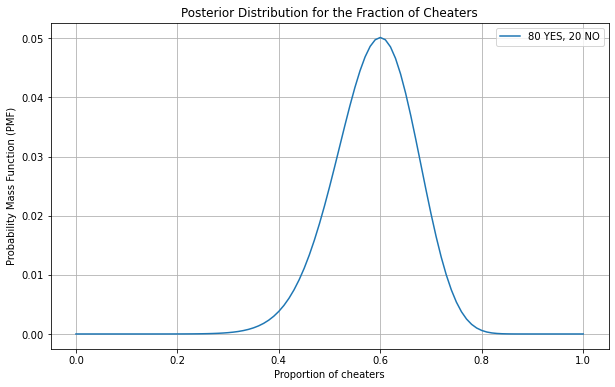

Most likely quantity in the posterior distribution: 0.6


In [26]:
# Define hypotheses
hypos = np.linspace(0, 1, 101)

# Create a uniform prior
prior = Pmf(1, hypos)

# Define likelihoods
likelihood = {'Y': 0.5 + hypos / 2, 'N': (1 - hypos) / 2}

# Define the dataset
dataset = 'Y' * 80 + 'N' * 20

# Update the prior with the dataset
posterior = prior.copy()
for data in dataset:
    posterior *= likelihood[data]

# Normalize the posterior
posterior.normalize()

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the posterior distribution
posterior.plot(label='80 YES, 20 NO')
plt.xlabel('Proportion of cheaters')
plt.ylabel('Probability Mass Function (PMF)')
plt.title('Posterior Distribution for the Fraction of Cheaters')
plt.legend()
plt.grid(True)
plt.show()

# Find the most likely quantity in the posterior distribution
most_likely_quantity = posterior.idxmax()
print("Most likely quantity in the posterior distribution:", most_likely_quantity)

**Exercise:** Suppose you want to test whether a coin is fair, but you don't want to spin it hundreds of times.
So you make a machine that spins the coin automatically and uses computer vision to determine the outcome.

However, you discover that the machine is not always accurate.  Specifically, suppose the probability is `y=0.2` that an actual heads is reported as tails, or actual tails reported as heads.

If we spin a coin 250 times and the machine reports 140 heads, what is the posterior distribution of `x`?
What happens as you vary the value of `y`?

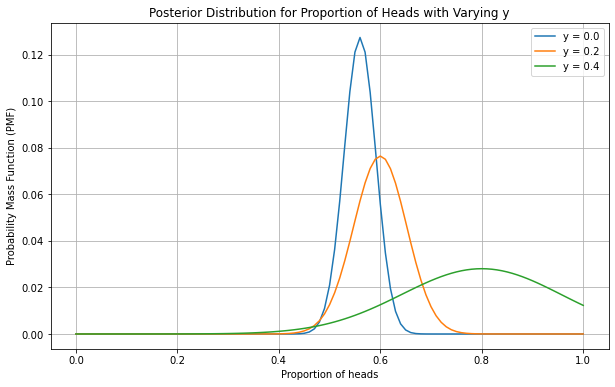

In [27]:
# Define the update function for the unreliable machine
def update_unreliable(pmf, dataset, y):
    likelihood = {
        'H': (1-y) * hypos + y * (1-hypos),
        'T': y * hypos + (1-y) * (1-hypos)
    }
    for data in dataset:
        pmf *= likelihood[data]

    pmf.normalize()

# Define hypotheses
hypos = np.linspace(0, 1, 101)

# Create a uniform prior
prior = Pmf(1, hypos)

# Define the dataset
dataset = 'H' * 140 + 'T' * 110

# Update the prior with the dataset for varying values of y
posterior00 = prior.copy()
update_unreliable(posterior00, dataset, 0.0)

posterior02 = prior.copy()
update_unreliable(posterior02, dataset, 0.2)

posterior04 = prior.copy()
update_unreliable(posterior04, dataset, 0.4)

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the posterior distributions for different values of y
posterior00.plot(label='y = 0.0')
posterior02.plot(label='y = 0.2')
posterior04.plot(label='y = 0.4')
plt.xlabel('Proportion of heads')
plt.ylabel('Probability Mass Function (PMF)')
plt.title('Posterior Distribution for Proportion of Heads with Varying y')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# Find the most likely value of x for each posterior distribution
most_likely_posterior00 = hypos[np.argmax(posterior00)]
most_likely_posterior02 = hypos[np.argmax(posterior02)]
most_likely_posterior04 = hypos[np.argmax(posterior04)]

print("Most likely value of x for y = 0.0:", most_likely_posterior00)
print("Most likely value of x for y = 0.2:", most_likely_posterior02)
print("Most likely value of x for y = 0.4:", most_likely_posterior04)

Most likely value of x for y = 0.0: 0.56
Most likely value of x for y = 0.2: 0.6
Most likely value of x for y = 0.4: 0.8


**Exercise:** In preparation for an alien invasion, the Earth Defense League (EDL) has been working on new missiles to shoot down space invaders.  Of course, some missile designs are better than others; let's assume that each design has some probability of hitting an alien ship, `x`.

Based on previous tests, the distribution of `x` in the population of designs is approximately uniform between 0.1 and 0.4.

Now suppose the new ultra-secret Alien Blaster 9000 is being tested.  In a press conference, an EDL general reports that the new design has been tested twice, taking two shots during each test.  The results of the test are confidential, so the general won't say how many targets were hit, but they report: "The same number of targets were hit in the two tests, so we have reason to think this new design is consistent."

Is this data good or bad? 
That is, does it increase or decrease your estimate of `x` for the Alien Blaster 9000?

Hint: If the probability of hitting each target is $x$, the probability of hitting one target in both tests
is $\left[2x(1-x)\right]^2$.

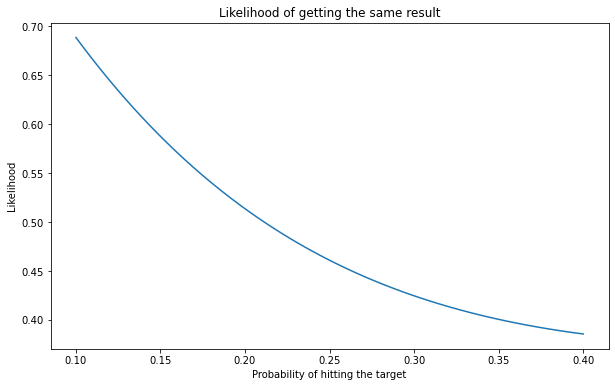

Maximum a posteriori estimate (MAP): 0.1


In [29]:
from empiricaldist import Pmf
from scipy.stats import binom

# Define hypotheses
hypos = np.linspace(0.1, 0.4, 101)
prior = Pmf(1, hypos)

# Compute the likelihood of getting the same result in both tests using binomial distribution
n = 2  # Number of shots per test
likes = [binom.pmf(k, n, hypos)**2 for k in range(n+1)]
likelihood = np.sum(likes, axis=0)

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the likelihood
plt.plot(hypos, likelihood)
plt.xlabel('Probability of hitting the target')
plt.ylabel('Likelihood')
plt.title('Likelihood of getting the same result')
plt.show()

# Update the prior with the likelihood
posterior = prior * likelihood
posterior.normalize()

# Find the maximum a posteriori estimate
map_estimate = hypos[np.argmax(posterior)]
print("Maximum a posteriori estimate (MAP):", map_estimate)

In [30]:
posterior = prior * likelihood
posterior.normalize()

49.12962799838001

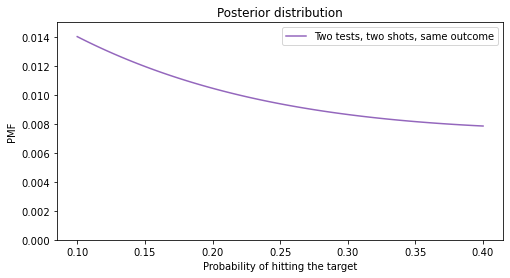

Getting the same result in both tests is more likely for extreme values of x.
In this example, the prior indicates that x is less than 0.5, and the update gives more weight to extreme values.
So the dataset makes lower values of x more likely.


In [31]:
from empiricaldist import Pmf
from scipy.stats import binom

# Define hypotheses
hypos = np.linspace(0.1, 0.4, 101)
prior = Pmf(1, hypos)

# Compute the likelihood of getting the same result in both tests using binomial distribution
n = 2  # Number of shots per test
likes = [binom.pmf(k, n, hypos)**2 for k in range(n+1)]
likelihood = np.sum(likes, axis=0)

# Update the prior with the likelihood
posterior = prior * likelihood
posterior.normalize()

# Set the figure size
plt.figure(figsize=(8, 4))

# Plot the posterior distribution
posterior.plot(label='Two tests, two shots, same outcome', color='C4')
plt.xlabel('Probability of hitting the target')
plt.ylabel('PMF')
plt.title('Posterior distribution')
plt.ylim([0, 0.015])
plt.legend()
plt.show()

# Explain the results
print("Getting the same result in both tests is more likely for extreme values of x.")
print("In this example, the prior indicates that x is less than 0.5, and the update gives more weight to extreme values.")
print("So the dataset makes lower values of x more likely.")